# Parallel computing with Julia
## Authors : Imane Momayiz and Nguyen Van Khoa

### Overview:
In this project, we aim to resolve a minimization problem using parallel computing. Thus, we preceed as follows:
* We implement a projected gradient algorithm with backtracking 
* We test the serial version of the algorithm 
* We test multiple parallel versions using different parallelization methods
* We validate the algorithm 
* We compare the performance of all versions 

__N.B__
We predicate our methodology on the hypothesis that the pixels are independent. Thus we minimize the loss function on each pixel and compute a gradient for each pixel rather than the whole image.


#### Preparing the environment

In [2]:
using Pkg
Pkg.add("Images")
Pkg.add("MAT")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %]  40.7 % [=================================>       ]  81.7 % Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [3]:
Pkg.add("ImageMagick")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [3]:
using MAT
using Plots
using Images
using Distributed

In [4]:
pyplot()
file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

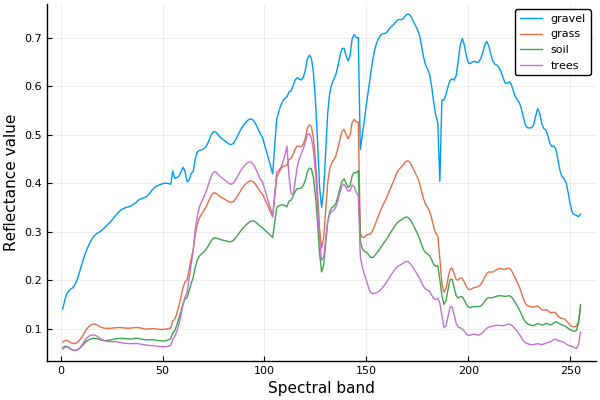

In [7]:
# visualize the endmembers to be used
plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

## Problem resolution

* To solve the minimization problem with the non-negativity constraint, we use a projected gradient algorithm with backtracking. 
* __NB__
We didn't take into consideration the second constraint of sum(an)=1


In [5]:
CPU_CORES = 4
addprocs(CPU_CORES - 1)

3-element Array{Int64,1}:
 2
 3
 4

In [6]:
procs()

4-element Array{Int64,1}:
 1
 2
 3
 4

In [7]:
workers()

3-element Array{Int64,1}:
 2
 3
 4

In [8]:
@everywhere f(a,S,x) = 1/2*(x-S*a)'*(x-S*a) #function to minimize = loss function

In [9]:
@everywhere ∇f(a,S,x) = S'*(-x +S*a) #gradient 

In [10]:
@everywhere function backtracking(an,f,∇f,d,S,x)
    """
    IN:
    ---
    x: initial point
    f, ∇f: function to be minimized and its gradient
    d: search direction
    S: endmember matrix
    an: abundance vector
    OUT:
    ----
    y: final point
    """
    α,β = 0.3, 0.6 # backtracking parameters
    t = 1;
    while f(an .+ t*d,S,x)[1] > (f(an,S,x) .+ α*t*∇f(an,S,x)'*d)[1]
        t = β*t
    end
    
    return t
end

In [11]:
#projection function that returns only positive components of input vector 
@everywhere projection(x) = max.(x,zeros(length(x)))

In [12]:
#projected gradient algorithm
@everywhere function pgm(f,∇f,x,S,ϵ,a0,γ,kmax)
   
    #initialization
    p = size(a0)[1]
    dk = ones(p,1)
    an = a0
    k = 0
    
    #searching for the minimum in the feasible space
    while (k <= kmax) && (norm(dk)>=ϵ)
        
        yk = projection(an - γ*∇f(an,S,x)) #yk belongs to the feasible space
        dk = yk - an #search direction 
        ## backtracking
        αk = backtracking(an,f,∇f,dk,S,x)
        an = an + αk*dk #we move towards the search direction with an optimal step size
        k = k + 1
        
    end
    
    return an;
    
end

In [59]:
@everywhere using LinearAlgebra: norm, opnorm
S = sources;
a0 = [1/4;1/4;1/4;1/4]
γ = 1/(2*opnorm(S'*S)); #step-size
ϵ = 10^-6; #precision
kmax = 100; #maximum number of iterations in the projected gradient algorithm
#we have chosen kmax based on many tests where we realized that the algorithm converges 

## Tests and validation

* To test and validate the algorithm, we implement serial and parallel versions on a small image and then visualise the new image found with the abundance matrix solution of our problem.

In [30]:
#defining image samples of different sizes for the tests and comparison
img_10 = img[1:10,1:10,:];
img_50 = img[1:50,1:50,:];
img_100 = img[1:100,1:100,:];

### Serial version Test

In [31]:
function serial_test(img,f,∇f,S,ϵ,a0,γ,kmax)
    """
    This function minimizes the loss function f for each pixel of the image
    N.B we suppose that the pixels are independent (null correlation),
        hence minimizing the loss function for the whole image is the same as minimizing it for each pixel
    """
    H =  size(img)[1] #height
    W = size(img)[2] #width
    A = zeros(4,H*W) #abundance matrix
    loss = 0
    
    for h in 1:H
        for w in 1:W
            pixel = img[h,w,:]
            an = pgm(f,∇f,pixel,S,ϵ,a0,γ,kmax)
            A[:,(h-1)*W + w] = an
            loss = loss + f(an,S,pixel)
            
        end
    end
    
    return A,loss
end

serial_test (generic function with 1 method)

In [ ]:
@time A_serial,loss_serial = serial_test(img_10,f,∇f,S,ϵ,a0,γ,kmax); 
@time A_serial,loss_serial = serial_test(img_50,f,∇f,S,ϵ,a0,γ,kmax);
@time A_serial,loss_serial = serial_test(img_100,f,∇f,S,ϵ,a0,γ,kmax); 
@time A_serial,loss_serial = serial_test(img,f,∇f,S,ϵ,a0,γ,kmax);

In [49]:
time_serial = Dict()
time_serial["t10"] = 0.130376
time_serial["t50"] = 2.812483
time_serial["t100"] = 11.866977
time_serial["tt"] = 102.272449 

102.272449

We can verify that only one CPU is being used.

<img src="images/serial.png">

### Parallel version Test

We implement different parallel computing methods: pmap, parallel loops and dynamic schedulling.

### Pmap

In [60]:
@everywhere using LinearAlgebra: norm, opnorm
function parallel_test_pmap(img,f,∇f,S,ϵ,a0,γ,kmax)
     
    H =  size(img)[1]    
    W = size(img)[2]
    P = size(S)[2]
    N = H*W
    
    print("Number of workers: ",nworkers())
    
    pixels =  [img[i,j,:] for i= 1:H for j=1:W]               
    A = pmap(x -> pgm(f,∇f,x,S,ϵ,a0,γ,kmax),pixels)
    
    # rearrange A
    A_arranged = zeros(4,H*W)
    for i in 1:N
        A_arranged[:,i] = A[i]
    end
    
    return A_arranged
end

parallel_test_pmap (generic function with 1 method)

In [ ]:
@time A = parallel_test_pmap(img_10,f,∇f,S,ϵ,a0,γ,kmax); 
@time A = parallel_test_pmap(img_50,f,∇f,S,ϵ,a0,γ,kmax); 
@time A = parallel_test_pmap(img_100,f,∇f,S,ϵ,a0,γ,kmax); 
@time A = parallel_test_pmap(img,f,∇f,S,ϵ,a0,γ,kmax); 

In [51]:
time_pmap = Dict()
time_pmap["t10"] = 0.107928
time_pmap["t50"] = 1.987046
time_pmap["t100"] = 7.870684
time_pmap["tt"] = 70.397237

70.397237

We can verify that all CPUs are being used.

<img src="images/pmap.png">

### Parallel Loops

In [17]:
# test argument
image = img_10;
#image = img_50;
#image = img_100;
#image = img;

In [18]:
H =  size(image)[1]    
W = size(image)[2]
N = H*W
pixels =  [image[i,j,:] for i= 1:H for j=1:W];

In [33]:
using SharedArrays
A_loops = SharedArray{Float64}(4,H*W)
@time @distributed (+) for i in 1:N
    A_loops[:,i] = pgm(f,∇f,pixels[i],S,ϵ,a0,γ,kmax);
end

 64.031531 seconds (629.32 k allocations: 547.245 MiB, 0.33% gc time)


4-element Array{Float64,1}:
 11336.708049908946
 23162.08615372361 
 23365.333639614546
 22302.030321840793

In [41]:
A_loops

4×90000 SharedArray{Float64,2}:
 0.0       0.0       0.0       0.0       …  0.144045  0.12607   0.110559
 0.390142  0.395255  0.400281  0.39497      0.249388  0.243377  0.239766
 0.358628  0.362089  0.365504  0.362859     0.255025  0.251228  0.249546
 0.45838   0.476883  0.496357  0.525394     0.156118  0.174666  0.171081

In [52]:
time_parallelloops = Dict()
time_parallelloops["t10"] = 0.132500
time_parallelloops["t50"] = 1.880003
time_parallelloops["t100"] = 7.042148
time_parallelloops["tt"] = 61.906846

61.906846

We can verify that all CPUs are being used.

<img src="images/parallelloops.png">

### Dynamic scheduling

We have implemented this version based on the explanation in the link below
https://stackoverflow.com/questions/37287020/how-and-when-to-use-async-and-sync-in-julia

In [23]:
# test argument
image = img_10;
#image = img_50;
#image = img_100;
#image = img;

In [24]:
H =  size(image)[1]    
W = size(image)[2]
N = H*W
pixels =  [image[i,j,:] for i= 1:H for j=1:W];

In [25]:
@everywhere function f_pmap(pgm,f,∇f,lst,S,ϵ,a0,γ,kmax)
    np = nprocs()            # Number of processes available.
    print("Number of processes: ",np,"\n")
    n  = length(lst)         # Number of elements to apply the function.
    results = zeros(4,n) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin # See below the discussion about all this part.
        for p = 1:np
            if p != myid() || np == 1
                @async begin
                    while true
                        idx = nextidx()
                        if idx > n
                            break
                        end
                        results[:,idx] = remotecall_fetch(pgm, p, f,∇f,lst[idx],S,ϵ,a0,γ,kmax)
                    end
                end
            end
        end
    end
    results
end

In [26]:
@time A_dynamic_scheduling = f_pmap(pgm,f,∇f,pixels,S,ϵ,a0,γ,kmax)

Number of processes: 4
 71.882384 seconds (8.81 M allocations: 1.125 GiB, 0.57% gc time)


4×90000 Array{Float64,2}:
 0.0       0.0       0.0       0.0       …  0.144045  0.12607   0.110559
 0.390142  0.395255  0.400281  0.39497      0.249388  0.243377  0.239766
 0.358628  0.362089  0.365504  0.362859     0.255025  0.251228  0.249546
 0.45838   0.476883  0.496357  0.525394     0.156118  0.174666  0.171081

In [53]:
time_dynamic = Dict()
time_dynamic["t10"] = 0.139399
time_dynamic["t50"] = 2.195006
time_dynamic["t100"] = 8.126911
time_dynamic["tt"] = 70.221609

70.221609

We can verify that all CPUs are being used.

<img src="images/dynamic.png">

### Validation

We validate our algorithm by visualising the obtained image thanks to the parallel version implementation of PGM (projected gradient method). (we obtain the same result using the other versions)

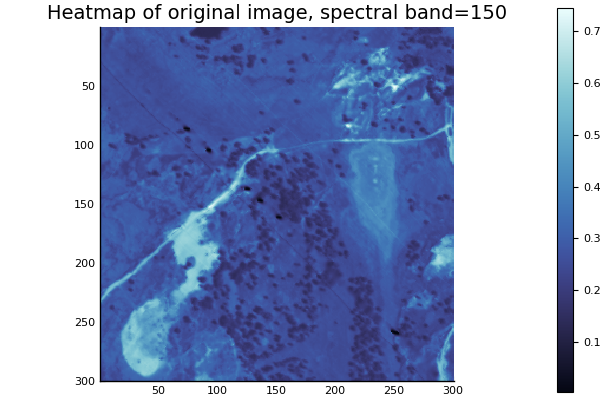

In [34]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice, title="Heatmap of original image, spectral band=150")

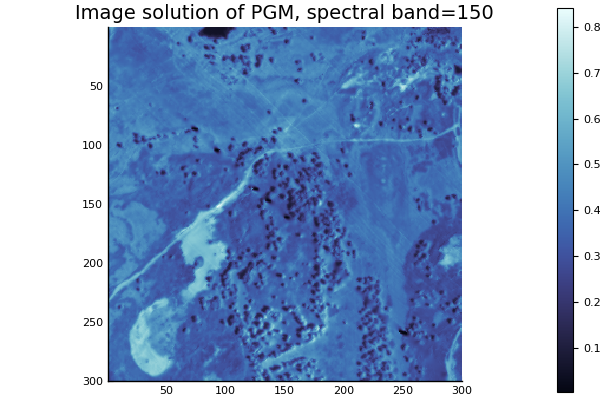

In [45]:
image_loops = reshape((S*A_loops)',(300,300,255))
p3 = heatmap(image_loops[:,:,109]',aspect_ratio=1, yflip = true,c=:ice,title="Image solution of PGM, spectral band=150")

### Original image

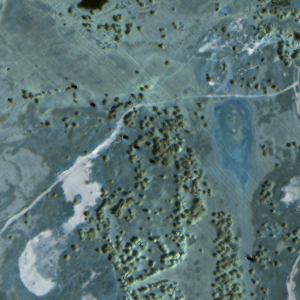

In [109]:
rgb = cat(1.35.*img[:,:,67],1.19.*img[:,:,109],1.09.*img[:,:,141],dims=3)
p4 = colorview(RGB,permutedims(rgb,(3,1,2)))

### Obtained image with PGM

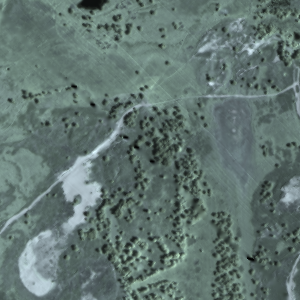

In [47]:
rgb2 = cat(1.35.*image_sched[:,:,67],1.19.*image_sched[:,:,109],1.09.*image_sched[:,:,141],dims=3)
p4 = colorview(RGB,permutedims(rgb2,(3,2,1)))

__ Comment: __
By comparing the original image with the obtained image in the 150th bandwidth and in rgb one,we observe that the projected gradient method works well in denoising the original image.

## Comparison

In [35]:
Pkg.add("StatPlots")

 Resolving package versions...
 Installed DataValueInterfaces ───────── v1.0.0
 Installed Widgets ───────────────────── v0.6.2
 Installed KernelDensity ─────────────── v0.5.1
 Installed StatPlots ─────────────────── v0.9.2
 Installed TableTraits ───────────────── v1.0.0
 Installed Observables ───────────────── v0.2.3
 Installed NearestNeighbors ──────────── v0.4.4
 Installed IterableTables ────────────── v1.0.0
 Installed IteratorInterfaceExtensions ─ v1.0.0
 Installed TableTraitsUtils ──────────── v1.0.1
 Installed DataValues ────────────────── v0.4.13
 Installed Clustering ────────────────── v0.13.3
  Updating `~/.julia/environments/v1.2/Project.toml`
  [60ddc479] + StatPlots v0.9.2
  Updating `~/.julia/environments/v1.2/Manifest.toml`
  [aaaa29a8] + Clustering v0.13.3
  [e2d170a0] + DataValueInterfaces v1.0.0
  [e7dc6d0d] + DataValues v0.4.13
  [1c8ee90f] + IterableTables v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [5ab0869b] + KernelDensity v0.5.1
  [b8a86587] + Near

In [36]:
using StatPlots

┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1242
┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
└ @ Widgets ~/.julia/packages/Widgets/451tD/src/utils.jl:63
┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
└ @ Widgets ~/.julia/packages/Widgets/451tD/src/utils.jl:63
┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
└ @ Widgets ~/.julia/packages/Widgets/451tD/src/utils.jl:63
┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
└ @ Widgets ~/.julia/packages/Widgets/451tD/src/utils.jl:63
┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
└ @ Widgets ~/.julia/packages/Widgets/451tD/src/utils.jl:63
┌ Warning: `@nodeps` is d


This package has been renamed to StatsPlots.
The name StatPlots has been deprecated.

Please run

`]rm StatPlots`
`]add StatsPlots`

Failure to update will mean that you do not receive new developments.



In [38]:
`]rm StatPlots`
`]add StatsPlots`

┌ Warning: special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = #shell_parse#353(::String, ::typeof(Base.shell_parse), ::String, ::Bool) at shell.jl:100
└ @ Base ./shell.jl:100


`']add' StatsPlots`

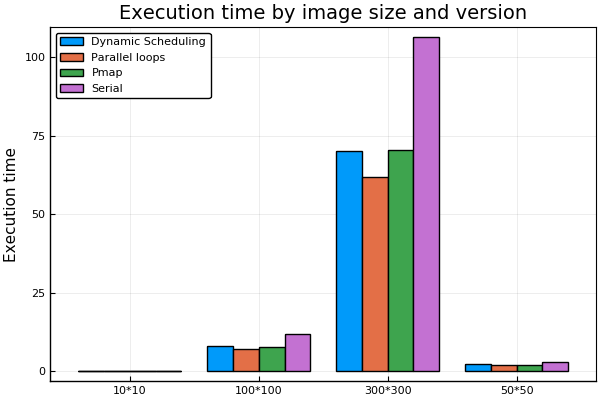

In [69]:
categories = ["Serial","Pmap","Parallel loops","Dynamic Scheduling"]
x = repeat(categories,inner=4)
nam = repeat(["10*10","50*50", "100*100","300*300"], outer = 4)
mn = [time_serial["t10"],time_serial["t50"],time_serial["t100"],time_serial["tt"],time_pmap["t10"],time_pmap["t50"],time_pmap["t100"],time_pmap["tt"],time_parallelloops["t10"],time_parallelloops["t50"],time_parallelloops["t100"],time_parallelloops["tt"],time_dynamic["t10"],time_dynamic["t50"],time_dynamic["t100"],time_dynamic["tt"]]
#time50 = [time_serial["t50"],time_pmap["t50"],time_parallelloops["t50"],time_dynamic["t50"]]
#bar(categories,time10)
#bar!(categories,time50)
#mn = [time10 time50]
groupedbar(nam, mn, group = x, ylabel = "Execution time", 
        title = "Execution time by image size and version",framestyle = :box)

In [54]:
#Dictionnaries of execution time per method
time_serial;
time_parallelloops;
time_dynamic;
time_pmap;

__Conclusion__:

* In our case, the serial version is slower than the parallel versions for all image sizes.
* However, the bigger the image sizes are the bigger the difference of execution time between serial and parallel versions.
* This shows that the parallelization is more relevant for big size data.
* In fact, the impact of overhead on total computional time is less significant in the case of big data,so we gain more advantages in parallel computing.